## Overview of the Problem set ##

**Problem Statement**: We are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

We will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [40]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Logistic_Regression_with_a_Neural_Network_mindset')

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import importlib
import lr_utils
importlib.reload(lr_utils)
from lr_utils import load_dataset, file_info

## Loading Dataset

In [42]:
path_train =  'datasets/train_catvnoncat.h5'
path_test = 'datasets/test_catvnoncat.h5'

print('Training Data')
file_info(path_train)
print('-' * 50)
print('\nTest Data')
file_info(path_test)

Training Data
Keys in file:
list_classes
train_set_x
train_set_y

Key: list_classes
Shape: (2,)
Data type: |S7

Key: train_set_x
Shape: (209, 64, 64, 3)
Data type: uint8

Key: train_set_y
Shape: (209,)
Data type: int64
--------------------------------------------------

Test Data
Keys in file:
list_classes
test_set_x
test_set_y

Key: list_classes
Shape: (2,)
Data type: |S7

Key: test_set_x
Shape: (50, 64, 64, 3)
Data type: uint8

Key: test_set_y
Shape: (50,)
Data type: int64


In [43]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [46]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


y = [1], it's a 'cat' picture.


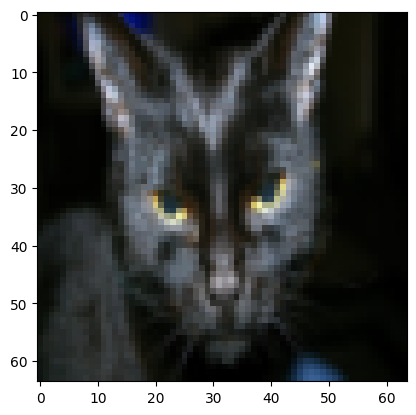

In [47]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [48]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [49]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

## General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

We will build a Logistic Regression, using a Neural Network mindset.

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
We will carry out the following steps:  
    - Initialize the parameters of the model  
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)  
    - Analyse the results and conclude  

## Building the parts of our algorithm ##

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

We often build 1-3 separately and integrate them into one function we call `model()`.

In [50]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [51]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

## Forward and Backward propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas we will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [52]:
def propagate(w, b, X, Y):
    """
    Implements forward and backward propagation for logistic regression.

    Arguments:
    w -- weights, shape: (num_features, 1)
    b -- bias, scalar
    X -- input data, shape: (num_features, m)
    Y -- true labels, shape: (1, m)

    Returns:
    grads -- dictionary with gradients "dw" and "db"
    cost  -- logistic regression cost
    """
    m = X.shape[1]

    # Forward propagation
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # Backward propagation
    dz = A - Y
    dw = np.dot(X, dz.T) / m
    db = np.sum(dz) / m

    grads = {"dw": dw, "db": db}
    cost = np.squeeze(cost)  # ensure cost is a scalar

    return grads, cost

## Optimization

The optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [53]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Optimizes parameters w and b using gradient descent.

    Arguments:
    w -- weights, shape: (num_features, 1)
    b -- bias, scalar
    X -- input data, shape: (num_features, m)
    Y -- true labels, shape: (1, m)
    num_iterations -- number of gradient descent steps
    learning_rate -- step size for gradient descent
    print_cost -- if True, prints cost every 100 iterations

    Returns:
    params -- dictionary with updated "w" and "b"
    grads -- dictionary with final gradients "dw" and "db"
    costs -- list of costs every 100 iterations (for plotting)
    """
    costs = []

    for i in range(num_iterations):
        # Compute cost and gradients
        grads, cost = propagate(w, b, X, Y)

        # Gradient descent update
        w -= learning_rate * grads["dw"]
        b -= learning_rate * grads["db"]

        # Store and optionally print cost
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.6f}")

    params = {"w": w, "b": b}
    grads = {"dw": grads["dw"], "db": grads["db"]}

    return params, grads, costs

## Predict

In [54]:
def predict(w, b, X):
    """
    Predicts binary labels (0 or 1) using learned logistic regression parameters w and b.

    Arguments:
    w -- weights, shape: (num_features, 1)
    b -- bias, scalar
    X -- input data, shape: (num_features, m)

    Returns:
    Y_prediction -- predicted labels, shape: (1, m)
    """
    # Compute predicted probabilities
    A = sigmoid(np.dot(w.T, X) + b)

    # Convert probabilities to binary predictions
    Y_prediction = (A > 0.5).astype(int)

    return Y_prediction

## Merge all functions into a model

In [55]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds and trains a logistic regression model.

    Arguments:
    X_train -- training data, shape: (num_features, m_train)
    Y_train -- training labels, shape: (1, m_train)
    X_test  -- test data, shape: (num_features, m_test)
    Y_test  -- test labels, shape: (1, m_test)
    num_iterations -- number of optimization steps
    learning_rate -- learning rate for gradient descent
    print_cost -- if True, prints cost every 100 iterations

    Returns:
    d -- dictionary containing model info: weights, bias, predictions, cost history, etc.
    """
    # Initialize parameters
    w, b = initialize_with_zeros(X_train.shape[0])

    # Optimize parameters
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Extract learned parameters
    w = params["w"]
    b = params["b"]

    # Predict on training and test sets
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # Print train/test accuracy
    if print_cost:
        train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
        test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
        print(f"Train accuracy: {train_acc:.2f} %")
        print(f"Test accuracy: {test_acc:.2f} %")

    # Return model details
    return {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }

In [56]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Train accuracy: 99.04 %
Test accuracy: 70.00 %


Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



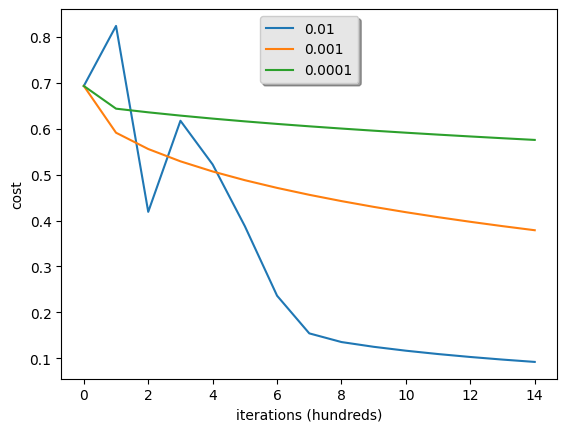

In [57]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [60]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.007, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.778332
Cost after iteration 200: 0.589491
Cost after iteration 300: 0.492116
Cost after iteration 400: 0.395530
Cost after iteration 500: 0.303775
Cost after iteration 600: 0.231449
Cost after iteration 700: 0.204820
Cost after iteration 800: 0.190106
Cost after iteration 900: 0.177450
Cost after iteration 1000: 0.166363
Cost after iteration 1100: 0.156544
Cost after iteration 1200: 0.147779
Cost after iteration 1300: 0.139903
Cost after iteration 1400: 0.132788
Cost after iteration 1500: 0.126331
Cost after iteration 1600: 0.120444
Cost after iteration 1700: 0.115058
Cost after iteration 1800: 0.110111
Cost after iteration 1900: 0.105554
Cost after iteration 2000: 0.101343
Cost after iteration 2100: 0.097441
Cost after iteration 2200: 0.093815
Cost after iteration 2300: 0.090439
Cost after iteration 2400: 0.087286
Cost after iteration 2500: 0.084338
Cost after iteration 2600: 0.081573
Cost after iteration 2700: 0.078978
Cost

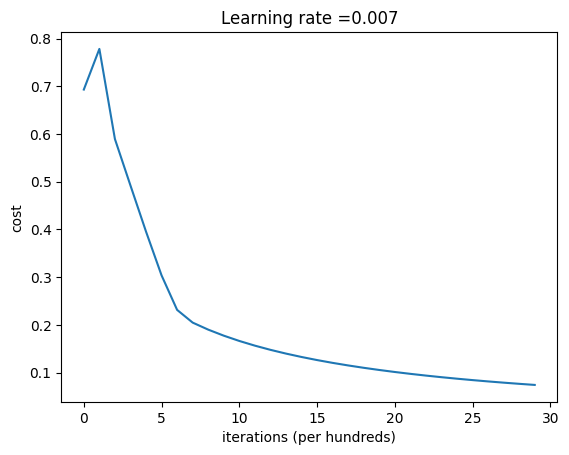

In [61]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

## Predictions

In [62]:
w = logistic_regression_model['w']
b = logistic_regression_model['b']

In [63]:
def display_predictions(indices, test_set_x, test_set_y, classes, w, b, num_px):
    """
    Displays multiple test images with their true labels and model predictions.

    Arguments:
    indices -- list of image indices to display
    test_set_x -- flattened and normalized test set, shape: (num_px*num_px*3, m_test)
    test_set_y -- true labels, shape: (1, m_test)
    classes -- list of class names (e.g., [b'non-cat', b'cat'])
    w, b -- learned parameters
    num_px -- width/height of each image
    """
    num_images = len(indices)
    cols = min(num_images, 5)
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(3.5 * cols, 3.5 * rows))

    for i, index in enumerate(indices):
        x = test_set_x[:, index].reshape(-1, 1)
        y_pred = predict(w, b, x)[0, 0]
        y_true = test_set_y[0, index]

        label_true = classes[y_true].decode("utf-8")
        label_pred = classes[y_pred].decode("utf-8")

        image = test_set_x[:, index].reshape((num_px, num_px, 3))

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {label_true}\nPred: {label_pred}", fontsize=10)

    plt.tight_layout()
    plt.show()


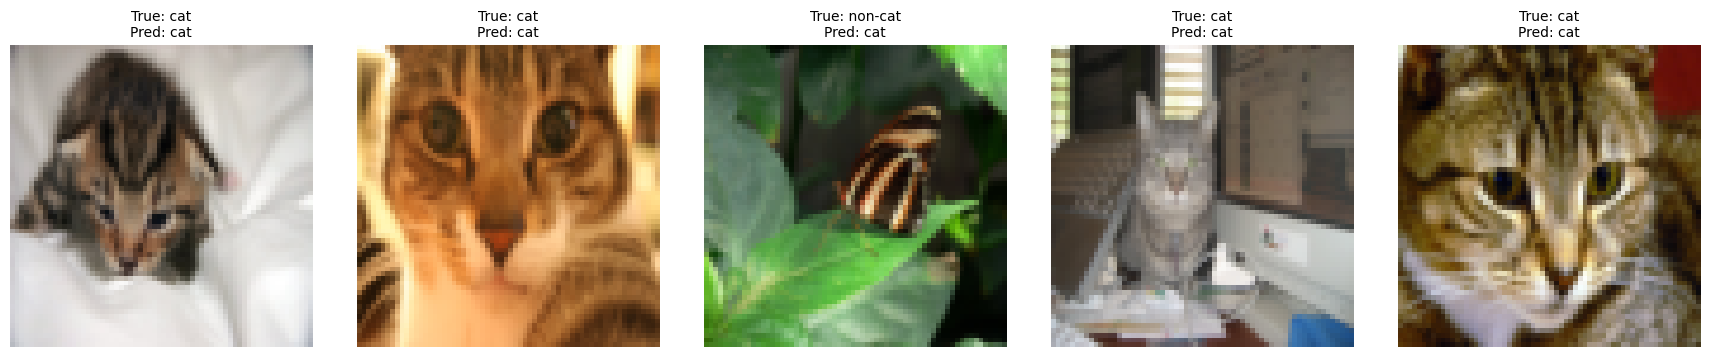

In [64]:
indices = [1, 3, 5, 7, 15]
display_predictions(indices, test_set_x, test_set_y, classes, w, b, num_px)
